In [1]:
## 同一ディレクトリ内にhttps://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g からダウンロードした学習済み単語ベクトルを配置しているものとする

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from gensim.models import KeyedVectors

DATASETPATH = '/content/drive/MyDrive/Colab Notebooks/NLP100/GoogleNews-vectors-negative300.bin' 

wv = KeyedVectors.load_word2vec_format(DATASETPATH, binary=True)

UnpicklingError: ignored

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-01-26 13:29:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  31.9MB/s    in 0.9s    

2023-01-26 13:29:50 (31.9 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [4]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 50の内容を複製

import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

with open('./newsCorpora.csv') as f:
   all_news = [news for news in f.readlines() if news.split('\t')[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

In [98]:
# 70
import numpy as np


NEWS_CATEGORIES = {
    'b' : 0,
    't' : 1,
    'e' : 2,
    'm' : 3
}


def vector_create(X, filepath):
  for x in X:
    news = x.split("\t")
    title, category = news[1], news[4]
    word_v = None
    for word in title.split(' '):
      if word:
        try:
          if word_v:
            word_v = word_v + wv[word] #. most_similarで抽出しようとするとメモリが死ぬため、データセットに存在する場合のみ扱う
          else:
            word_v = wv[word]
        except:
          continue
    if word_v is None:
      word_v = np.zeros(300)
    with open(f'./{filepath}_x.txt', mode='a') as f:
        f.write(str(','.join(list([str(char) for char in word_v]))) + '\n')
    y = NEWS_CATEGORIES[news[4]]
    with open(f'./{filepath}_y.txt', mode='a') as f:
      f.write(str(y) + '\n')

vector_create(train_data, 'train')
vector_create(valid_data, 'valid')
vector_create(test_data, 'test')

In [22]:
vector_create(valid_data, 'valid')
vector_create(test_data, 'test')

In [66]:
# 71
import csv
from scipy.special import softmax


X_14 = []
with open(f'./train_x.txt', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    if i == 4:
      break
    X_14.append(row)
    i += 1
  X_14 = np.array(X_14, dtype=np.float64)

W = np.zeros((X_14.shape[1], len(NEWS_CATEGORIES)))

y_hat1 = softmax(np.dot(X_14[0], W))
p = softmax(np.dot(W, X_14[0]))
index = np.where(p == np.max(p))
print(f'y_hat1: {y_hat1[index]}')
Y_hat = softmax(np.dot(X_14, W))
print(f'Y_hat: {Y_hat}')


y_hat1: [0.25 0.25 0.25 0.25]
Y_hat: [[0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]]


In [68]:
# 72
Y_14 = []
with open(f'./train_y.txt', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    if i == 4:
      break
    Y_14.append(int(row.strip()))
    i += 1
Y_14 = np.array(Y_14)
l1 = np.log(Y_hat[Y_14[0]])
print(f'l1: {l1}')
gradient1 = (Y_14[0] - Y_hat[0][Y_14[0]]) * X_14[0]
print(f'gradient1: {gradient1}')

l1: [-2.77258872 -2.77258872 -2.77258872 -2.77258872]
gradient1: [ 6.43310547e-02  2.19955443e-02 -1.82586667e-01  2.51647944e-01
  8.89282236e-02 -2.16644287e-01 -6.09252920e-01 -1.74072266e-01
  1.43798828e-01  3.19290157e-02  2.45971680e-02  1.93939208e-01
  1.36230469e-01  9.69696042e-02 -2.27996824e-01 -4.06799321e-02
  4.46533203e-01  4.10583491e-01  8.60900884e-02 -4.71130366e-01
 -1.88262942e-01 -8.23059106e-02  5.37353516e-01  1.07849120e-01
  8.86917111e-03 -2.47154242e-02  2.98950205e-01  3.34899897e-01
 -3.66592399e-02  2.36511226e-01 -1.24877930e-01  9.79156506e-02
  9.98077395e-02  1.50421145e-01 -1.53259273e-01  1.07612606e-02
  7.07641611e-01  4.99511719e-01 -3.68957524e-02 -6.57501223e-02
  8.65631096e-02 -8.51440420e-02  2.33673098e-01 -4.63562007e-01
  4.13894659e-02  7.23724373e-02 -1.38122554e-01  7.14263909e-02
  3.02734375e-01  2.85705571e-01 -3.97338858e-01  3.95446772e-01
  3.23547368e-01 -1.91101069e-01  8.94012449e-02  3.27331538e-01
  2.13806148e-01  5.48706

In [69]:
ls = []
for i in range(4):
  l = -1 * np.log(Y_hat[Y_14[i]])
  ls.append(l)
gradient = gradient1
print(np.average(l))
for i in range(1,4):
  gradient += (Y_14[i] - Y_hat[i][Y_14[i]]) * X_14[i]
gradient = gradient / 4
print(f'gradient: {gradient}')

2.772588722239781
gradient: [-0.02205658  0.14985466 -0.22924995  0.19368363 -0.03162694 -0.01949501
 -0.1897707  -0.13913727  0.18624115  0.1212635   0.13915253 -0.10228729
  0.08578682  0.1925354  -0.24700164 -0.12080765  0.10158414  0.05297851
 -0.0154953  -0.02142715  0.10708618  0.002388    0.16466522  0.19549561
  0.13808918 -0.08689785  0.16872073  0.20452118 -0.01576424  0.20904159
 -0.24517823 -0.0902462  -0.08080673  0.08433342  0.09888458 -0.10902691
  0.42423249  0.24896622 -0.09225464  0.09137344  0.29970169 -0.15019226
  0.16407633  0.01082611  0.10222626 -0.01609993 -0.23427582  0.04071426
  0.20041466  0.23514938 -0.29210376  0.23639261  0.07300949 -0.26922226
  0.13833618  0.03823852  0.01873207 -0.20552826 -0.28965092 -0.06984329
  0.11265182  0.08146096 -0.11690521 -0.04460049  0.10717011  0.08165741
 -0.42388916 -0.07542038 -0.05912399 -0.10589218  0.05565262 -0.20921707
  0.11833573  0.19696808 -0.0970459  -0.1510601   0.16059876  0.07807541
 -0.08300018  0.0382156

In [111]:
# 73

EPOCH = 100

X = []
with open(f'./train_x.txt', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)

W = np.zeros((len(NEWS_CATEGORIES), X_14.shape[1]))

Y = []
with open(f'./train_y.txt', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

eta = 1.0
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]))
  l = -1 * np.log(y_hat[Y[i]])
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
print(W)

[[-0.04038221 -0.46974491  0.09572526 ...  1.32352376  0.04513307
  -0.14458064]
 [-0.18046285 -0.15350312  0.30392548 ...  0.37491862  0.42854704
  -0.36254766]
 [ 0.15617263  0.5315017  -0.22241033 ... -1.43765294 -0.28792394
   0.2608731 ]
 [ 0.06467243  0.09174633 -0.17724042 ... -0.26078943 -0.18575617
   0.2462552 ]]


In [129]:
# 74
correct = 0
for i in range(X.shape[0]):
  p = softmax(np.dot(W, X[i]))
  index = np.where(p == np.max(p))
  if (Y[i][index] == 1)[0]:
    correct += 1
print(correct/X.shape[0])


0.6483526769000374


In [137]:
# 75

EPOCH = 100

X = []
with open(f'./train_x.txt', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)


Y = []
with open(f'./train_y.txt', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

W = np.zeros((len(NEWS_CATEGORIES), X.shape[1]))


valid_X = []
with open(f'./valid_x.txt', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.txt', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)


eta = 1.0
train_losses = []
train_correctness = []
test_losses = []
test_correctness = []
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]))
  l = -1 * np.log(y_hat[Y[i]])
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
  correct = 0
  l = 0
  for i in range(X.shape[0]):
    p = softmax(np.dot(W, X[i]))
    index = np.where(p == np.max(p))
    l += np.average(-1 * np.log(p))
    if (Y[i][index] == 1)[0]:
      correct += 1
  train_losses.append(l)
  train_correctness.append(correct/X.shape[0])

  correct = 0
  l = 0
  for i in range(valid_X.shape[0]):
    p = softmax(np.dot(W, valid_X[i]))
    index = np.where(p == np.max(p))
    l += np.average(-1 * np.log(p))
    if (valid_Y[i][index] == 1)[0]:
      correct += 1
  test_losses.append(l)
  test_correctness.append(correct/valid_X.shape[0])


[16536.230522911737, 17017.145143868074, 19743.07294197545, 22070.795766253457, 22223.278767077078, 22177.115108765884, 24727.352343930364, 24772.433769390973, 24090.185377144524, 24854.312127336678, 25235.058984512296, 26073.77072051114, 41598.786724539015, 42043.757700945775, 42728.416098012225, 45036.66510935103, 45808.38628500885, 48054.025200441, 48705.21775542195, 47613.94120255265, 47578.67754829805, 48037.18630738594, 48082.54973615611, 48185.75710888867, 49850.50968496895, 49904.01828871804, 47437.64988120663, 46160.29756198144, 47219.2671439818, 47408.94521466166, 48570.180991836205, 48589.579611073124, 48628.83002841167, 49022.351380642176, 49182.76523902221, 49249.38317571565, 49249.67737054252, 49249.68939219656, 54419.71561879293, 54819.25334662284, 51191.37600532549, 52542.976952747835, 51640.767811273785, 51648.005978320194, 51662.22041020544, 52005.49538126586, 52635.68154608864, 53489.881420071324, 53534.28972967491, 49608.9020639817, 49766.13935319072, 49906.53225923

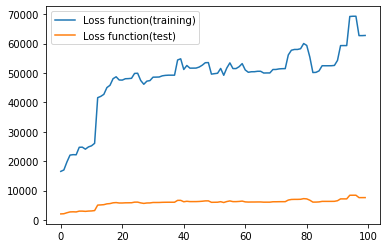

In [138]:
import matplotlib.pyplot as plt
print(train_losses)
plt.plot([i for i in range(EPOCH)], train_losses, label="Loss function(training)")
plt.plot([i for i in range(EPOCH)], test_losses, label="Loss function(test)")

plt.legend()
plt.show()

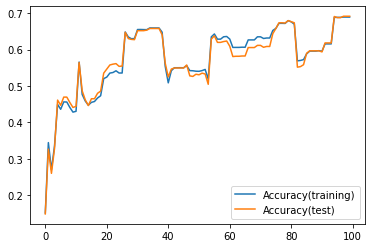

In [139]:
plt.plot([i for i in range(EPOCH)], train_correctness, label="Accuracy(training)")
plt.plot([i for i in range(EPOCH)], test_correctness, label="Accuracy(test)")

plt.legend()
plt.show()